# Practical 1 - Motion Estimation

## Setup

### Import necessay libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib.patches import Polygon

### Import images

#### Utility functions

In [2]:
def load_image(path: str) -> np.ndarray:
    """
    Load image from path and convert it to RGB
    
    :param path: path to image
    :return: image in RGB
    """
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def display_image(img: np.ndarray, title: str = "") -> None:
    """
    Display image with matplotlib

    :param img: image to display
    :param title: title of the image
    """
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis('off')
    plt.show()

#### Load images and display chosen samples

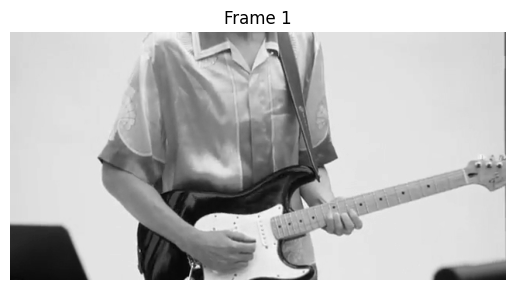

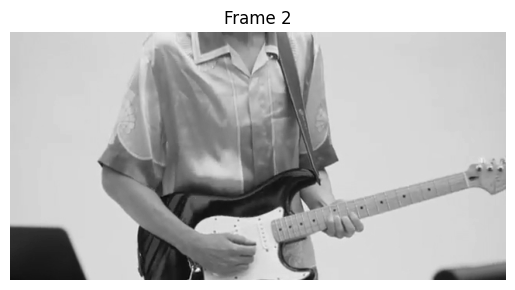

In [3]:
# Load two consecutive frames
frame1: np.ndarray = load_image("./images/Part1/LF000.jpg")
frame2: np.ndarray = load_image("./images/Part1/LF001.jpg")

# Display chosen frames
display_image(frame1, "Frame 1")
display_image(frame2, "Frame 2")

## A - Pixel wise motion estimation

In [4]:
def pixel_wise_motion_estimation(frame1: np.ndarray, frame2: np.ndarray, neighborhood: int = 5) -> tuple[np.ndarray]:
    """
    Compute the motion estimation between two frames using pixel-wise motion estimation

    :param frame1: first frame
    :param frame2: second frame
    :return: motion vectors
    """
    assert frame1.shape == frame2.shape, "Frames must have the same shape"

    frame_shape = frame1.shape
    frame1 = frame1 / 255
    frame2 = frame2 / 255

    v_x = np.zeros(frame_shape, dtype='int')
    v_y = np.zeros(frame_shape, dtype='int')

    for i in range(frame_shape[0]):
        for j in range(frame_shape[1]):
            min_x = max(0, i - neighborhood)
            max_x = min(frame_shape[0], i + neighborhood)

            min_y = max(0, j - neighborhood)
            max_y = min(frame_shape[1], j + neighborhood)

            E = np.inf
            new_x = 0
            new_y = 0

            for k in range(min_x, max_x):
                should_break = False
                for l in range(min_y, max_y):
                    if frame1[k, l] == frame2[i, j] and (k == i and l == j):
                        new_x = 0
                        new_y = 0
                        should_break = True
                        break
                    
                    E_new = (frame2[k, l] - frame1[i, j]) ** 2
                    diff_x = k - i
                    diff_y = l - j
                    
                    if E_new < E:
                        E = E_new
                        new_x = diff_x
                        new_y = diff_y
                    elif E_new == E and (diff_x < new_x or diff_y < new_y):
                        new_x = diff_x
                        new_y = diff_y

                if should_break:
                    break
            
            v_x[i, j] = new_x
            v_y[i, j] = new_y
    
    return v_x, v_y

In [5]:
# Compute motion estimation
motion_x, motion_y = pixel_wise_motion_estimation(frame1, frame2, neighborhood=3)

### Visualize motion vectors

(64,) (32,) (320, 640) (320, 640)


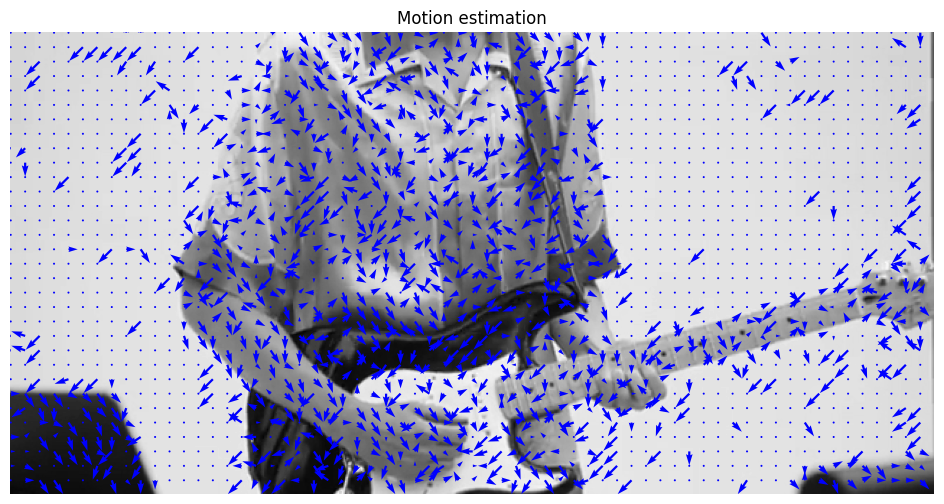

In [6]:
def display_motion_estimation(u: np.ndarray, v: np.ndarray, frame: np.ndarray, step: int = 5) -> None:
    """
    Display the motion estimation between two frames

    :param u: first frame
    :param v: second frame
    """
    # Pixel coordinates
    x_coords = np.arange(0, frame1.shape[1], step)
    y_coords = np.arange(0, frame1.shape[0], step)

    print(x_coords.shape, y_coords.shape, u.shape, v.shape)

    u = u[::step, ::step]
    v = v[::step, ::step]

    _, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.imshow(frame, cmap='gray')
    ax.set_axis_off()
    ax.set_title('Motion estimation')
    
    ax.quiver(x_coords, y_coords, u, v, scale=200, color='blue')
    plt.show()

# Display motion estimation
display_motion_estimation(motion_x, motion_y, frame1, step=10)

## B - Block Matching Algorithm (BMA)

In [7]:
def BMA(frame1: np.ndarray , frame2: np.ndarray, block_size: int = 16, window_size: int = 7) -> tuple[np.ndarray]:
    """
    Compute the motion estimation between two frames using the block matching algorithm

    :param frame1: first frame
    :param frame2: second frame
    :return: motion vectors
    """
    assert frame1.shape == frame2.shape, "Frames must have the same shape"

    frame_shape = frame1.shape
    frame1 = frame1 / 255
    frame2 = frame2 / 255

    r_i = range(0, frame_shape[0], block_size)
    r_j = range(0, frame_shape[1], block_size)
    l_r_i = len(r_i)
    l_r_j = len(r_j)

    v_x = np.zeros((l_r_i, l_r_j), dtype='int')
    v_y = np.zeros((l_r_i, l_r_j), dtype='int')

    for i in r_i:
        for j in r_j:
            current_block = frame1[i:i+block_size, j:j+block_size]

            E = np.inf
            new_x = 0
            new_y = 0

            for k in range(i - window_size, i + window_size):
                should_break = False
                for l in range(j - window_size, j + window_size):
                    if k == i and l == j and frame1[i, j] == frame2[k, l]:
                        new_x = 0
                        new_y = 0
                        should_break = True

                    new_block = frame2[k:k+block_size, l:l+block_size]
                    if new_block.shape != current_block.shape:
                        continue

                    E_new = np.sum(np.abs((new_block - current_block)) ** 2)

                    diff_x = k - i
                    diff_y = l - j

                    if E_new < E:
                        E = E_new
                        new_x = diff_x
                        new_y = diff_y
                    
                    elif E_new == E and (diff_x < new_x or diff_y < new_y):
                        new_x = diff_x
                        new_y = diff_y
                
                if should_break:
                    break

            v_x[i // block_size, j // block_size] = new_x
            v_y[i // block_size, j // block_size] = new_y

    return v_x, v_y

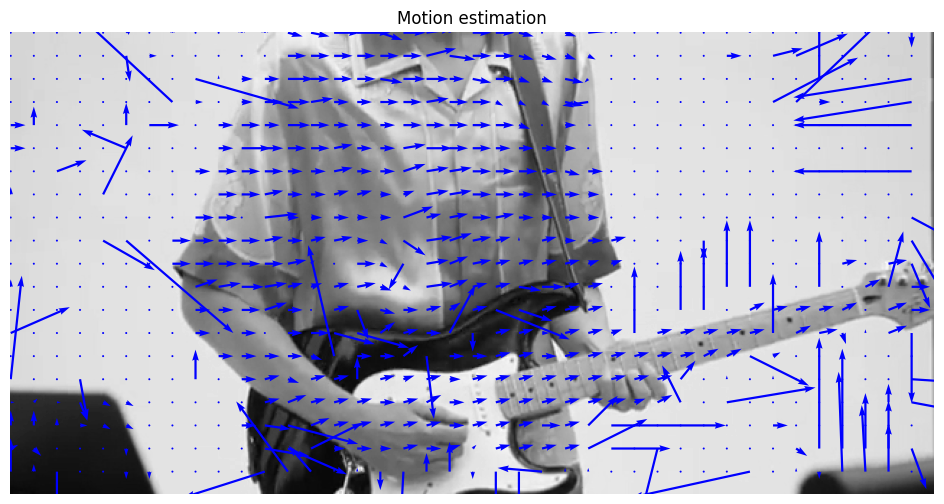

In [8]:
def BMA_display(frame1: np.ndarray, frame2: np.ndarray, block_size: int = 16, window_size: int = 10) -> None:
    v_x , v_y = BMA(frame1, frame2, block_size=block_size, window_size=window_size)

    x_coords = np.arange(0, frame1.shape[1], block_size)
    y_coords = np.arange(0, frame1.shape[0], block_size)

    _, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.imshow(frame1, cmap='gray')
    ax.set_axis_off()
    ax.set_title('Motion estimation')

    ax.quiver(x_coords, y_coords, v_x, v_y, scale=250, color='blue')
    plt.show()

BMA_display(frame1, frame2, block_size=16, window_size=32)

## D - Node based algorithm

Chargons dans un premier temps les images fournies.

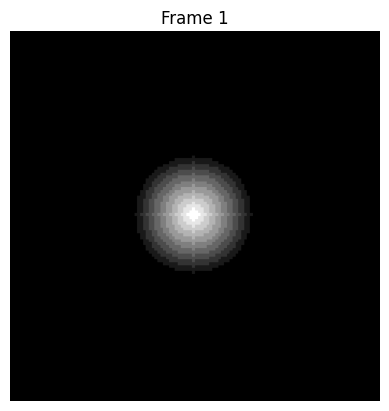

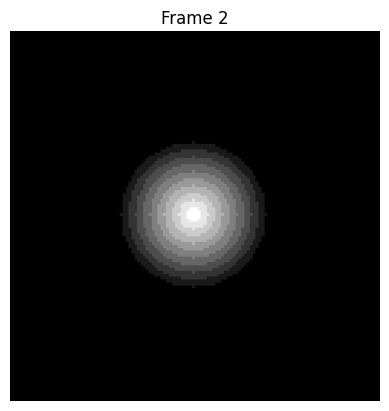

In [9]:
pic1: np.ndarray = load_image("./images/Part2/1.png")
pic2: np.ndarray = load_image("./images/Part2/2.png")

# Display provided frames
display_image(pic1, "Frame 1")
display_image(pic2, "Frame 2")

On peut dès à présent se donner quelques hyperparamètres.

In [10]:
IMG_HEIGHT = pic1.shape[0]
IMG_WIDTH = pic1.shape[1]
BLOCK_SIZE = ((IMG_HEIGHT + IMG_HEIGHT) // 2) // 4
LEARNING_RATE = 0.001
EPOCHS = 10

print(f'Block size: {BLOCK_SIZE}')

Block size: 150


L'étape suivante est de déterminer les positions des blocs initiaux dans l'image de référence : `pic1`

In [11]:
def get_blocks_positions(img: np.ndarray, block_size: int) -> np.ndarray:
    """
    Compute the positions of the blocks in the image

    :param img: image
    :param block_size: size of the blocks
    :return: blocks positions
    """
    blocks: list = []

    # Determine blocks positions
    for j in range(0, img.shape[0], block_size):
        for i in range(0, img.shape[1], block_size):
            block: list = []
            block.append([i, j])
            block.append([i, j + block_size])
            block.append([i + block_size, j + block_size])
            block.append([i + block_size, j])
            
            # Add block to list
            blocks.append(block)
    
    return np.array(blocks)

blocks = get_blocks_positions(pic1, BLOCK_SIZE)
print(f'Number of blocks: {blocks.shape[0]}')

Number of blocks: 16


Vérifions que les blocs sont bien placés en les affichant sur l'image de référence.

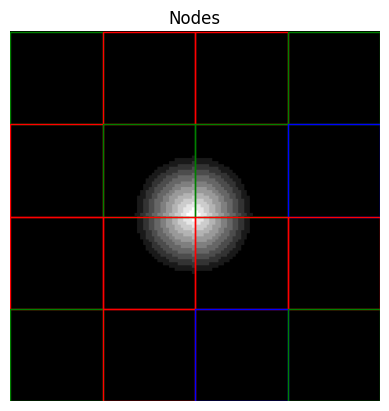

In [12]:
def display_nodes(img: np.ndarray, nodes: np.ndarray) -> None:
    """
    Display the nodes in the image

    :param img: image
    :param nodes: nodes
    """
    _, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_axis_off()
    ax.set_title('Nodes')

    for node in nodes:
        ax.add_patch(
            Polygon(node, linewidth=1, edgecolor=np.random.choice(['red', 'green', 'blue']), facecolor='none')
        )
    
    plt.show()

display_nodes(pic1, blocks)

Avant de commencer l'algorithme, il faut définir les polynômes d'interpolation $\Phi_k$.

In [13]:
def phi(pos: tuple[int, int], pos_min: tuple[int, int], pos_max: tuple[int, int]) -> list[float]:
    """
    Compute the phi functions (interpolation kernel)
    :param pos: position
    :param pos_min: minimum position
    :param pos_max: maximum position
    :return: phi functions (interpolation kernel)
    """
    x, y = pos
    
    x_min, y_min = pos_min
    x_max, y_max= pos_max

    cst = ((x_max - x_min) * (y_max - y_min))

    # Compute phi functions in regards to
    # the polynomials formulas
    phi_1 = (x_max - x) * (y_max - y) / cst
    phi_2 = (x - x_min) * (y_max - y) / cst
    phi_3 = (x_max - x) * (y - y_min) / cst
    phi_4 = (x - x_min) * (y - y_min) / cst

    return [phi_1, phi_2, phi_3, phi_4]

Nous pouvons maintenant définir une fonction d'énergie $E_{dfd}$ (Displaced Frame Difference).

In [14]:
def displaced_frame_difference(d_b: np.ndarray, frame1: np.ndarray, frame2: np.ndarray, block_positions: np.ndarray) -> float:
    """
    Compute the displaced frame difference energy between two frames

    :param d: motion vector
    :param frame1: first frame
    :param frame2: second frame
    :param block: block
    :return: displaced frame difference
    """

    # Get the min and max positions of the blocks
    x_min, x_max = block_positions[:, 0].min(), block_positions[:, 0].max()
    y_min, y_max= block_positions[:, 1].min(), block_positions[:, 1].max()
   
    E_dfd: float = 0
    
    # Iterate over every pixel in the block
    for x in range(x_min, x_max):
        for y in range(y_min, y_max):
            d = d_b.copy()
            # Compute the interpolation kernel
            phi_tup = phi((x, y), (x_min, y_min), (x_max, y_max))

            for k in range(d_b.shape[0]):
                d += phi_tup[k] * d_b[k]
            
            d = d.sum(axis=0)
            # Compute the new position
            new_pos = np.array([x, y]) + d.astype(int)
            new_pos = np.clip(new_pos, 0, frame1.shape[0] - 1)
            
            # Compute the displaced frame difference
            E_dfd += abs(frame2[new_pos[0], new_pos[1]] - frame1[x, y])

    return E_dfd

<u>Remarques :</u>
* Nous avons choisi de ne pas prendre en compte les pixels qui ne sont pas dans l'image de référence. Cela permet de ne pas avoir à gérer les cas où le bloc est en dehors de l'image.
* Pour la fonction $E_{dfd}$, nous utilisons ici la différence moyenne absolue. Par expérimentation, les résultats avec l'erreur quadratique moyenne étaient bien moins bons.

Maintenant que nous avons une fonction nous permettant de calculer l'enéregie / erreur de l'estimation de mouvement, nous devons définir une fonction nous permettant de réduire, et ainsi minimiser cette énergie. Dans notre cas, nous allons utiliser l'algorithme de descente de gradient, afin de déterminer les meilleurs paramètres $\vec{d_{k}}$.

In [15]:
def compute_block_displacement(frame1: np.ndarray, frame2: np.ndarray, block: np.ndarray, d: np.ndarray, learning_rate: float, epochs: int) -> np.ndarray:
    """
    Compute the displaced blocks
    :param frame1: first frame
    :param frame2: second frame
    :param blocks: blocks
    :param d: motion vector
    :return: displaced blocks
    """
    # Iterate over the number of epochs
    for _ in range(epochs):
        # Compute the displaced frame difference
        E_dfd = displaced_frame_difference(d, frame1, frame2, block)

        # Initialize the gradient
        gradient = np.zeros((4, 2))
        for i in range(gradient.shape[0]):
            for j in range(gradient.shape[1]):
                diff_d = d.copy()
                # Compute an approximation of the partial derivative of the displaced frame difference
                # according to the d[i, j] parameter
                diff_d[i, j] += 1
                diff_E_dfd = displaced_frame_difference(diff_d, frame1, frame2, block)
                # Compute the gradient
                gradient[i, j] = (diff_E_dfd - E_dfd)

        # Update the motion parameters according to the gradient and the learning rate
        d = d - learning_rate * gradient

        # Stop the algorithm if overall update is too small (the algorithm converged)
        # Else with continue the gradient descent
        if np.abs(gradient).mean() * learning_rate < 0.1:
            break

    return d

Enfin, nous pouvons calculer les nouveaux blocs, en détermiant leurs déplacements.

In [16]:
d_new = np.zeros(blocks.shape)
for i in range(blocks.shape[0]):
    d_new[i] = compute_block_displacement(
        frame1=pic1,
        frame2=pic2,
        block=blocks[i],
        d=d_new[i],
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS
    )
new_blocks = blocks + d_new

/var/folders/6w/l_4p050n0js7pwx4t7cb7k5r0000gn/T/ipykernel_14844/2583763048.py:34: RuntimeWarning: overflow encountered in ubyte_scalars
  E_dfd += abs(frame2[new_pos[0], new_pos[1]] - frame1[x, y])


Affichons le résultat ces nouveaux blocs sur l'image de référence.

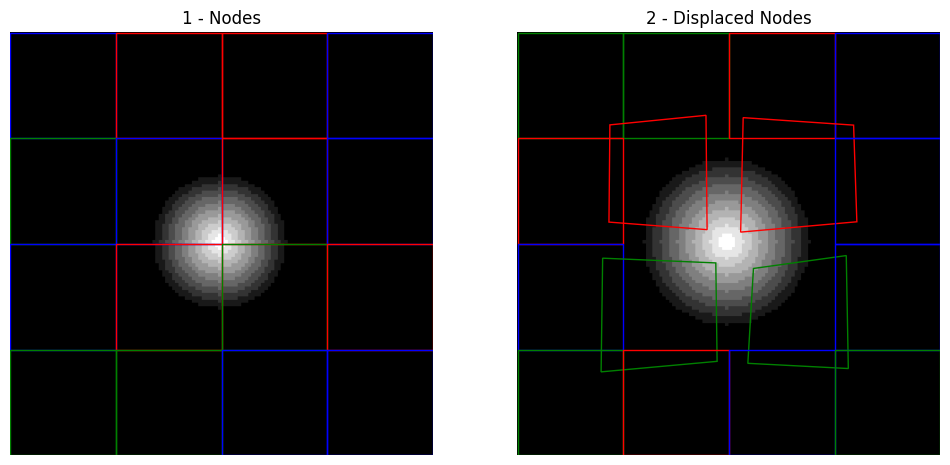

In [17]:
def display_nodes_difference(img1: np.ndarray, img2: np.ndarray, nodes1: np.ndarray, nodes2: np.ndarray) -> None:
    """
    Display the nodes in the image

    :param img1: First image
    :param img2: Second image
    :param nodes1: nodes of the first image
    :param nodes2: nodes of the second image
    """
    _, ax = plt.subplots(1, 2, figsize=(12, 12))
    ax[0].imshow(img1, cmap='gray')
    ax[0].set_axis_off()
    ax[0].set_title('1 - Nodes')

    ax[1].imshow(img2, cmap='gray')
    ax[1].set_axis_off()
    ax[1].set_title('2 - Displaced Nodes')

    for node in nodes1:
        ax[0].add_patch(
            Polygon(node, linewidth=1, edgecolor=np.random.choice(['red', 'green', 'blue']), facecolor='none')
        )
    
    for node in nodes2:
        ax[1].add_patch(
            Polygon(node, linewidth=1, edgecolor=np.random.choice(['red', 'green', 'blue']), facecolor='none')
        )
    
    plt.show()

display_nodes_difference(pic1, pic2, blocks, new_blocks)

Comme nous pouvons le constater, **seuls** les noeuds des blocks contenant uniquement des pixels noirs **dans les deux images** n'ont pas bougé. En effet, les pixels ne bougeant pas entre deux images, alors l'énegie $E_{dfd}$ est nulle (donc minimale).</br>
En revanche, le motif central s'est agrandi, provoquant alors un mouvement des noeuds des blocs concernés (les blocs centraux). On remarque aussi que des pixels sont passés de noirs à blancs / gris, provoquant là aussi mouvement des noeuds.